### Introduction

### Approach

### Simulation Notes
In order to run monte-carlo simulations quickly, we use a branch of mechaFIL which accepts the baseline power array and starting network_zero_cum_capped_power, use the `arg_for_baseline_power_array` branch of mechaFIL when running this notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import matplotlib.dates as mdates

from datetime import timedelta, date, datetime
import time
import os
import pickle

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

import mechafil.minting as minting
import mechafil.data as mecha_data
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, setup_spacescope
from mechafil.power import forecast_power_stats, build_full_power_stats_df, scalar_or_vector_to_vector
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

from cel_utils import disk_utils

from joblib import Parallel, delayed
import dill as pickle
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects

In [3]:
NDEVICES = 4 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

today = date(2023, 6, 30)
DATA_LAG_DAYS = 2
current_date = today - timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - date(2020, 10, 15)).days

start_date = date(2023, 6, 1)  # seed network w/ data uptil this date
start_day = (start_date - date(2020, 10, 15)).days

# Forecast
forecast_lenght = 365 * 5
end_day = current_day + forecast_lenght
end_date = current_date + timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)
duration = 365 # sector duration

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

auth_config='/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
setup_spacescope(auth_config)

class ArrayWrapperObj:
    def __init__(self, arr):
        self.arr = arr
    def get(self):
        return self.arr

2023-06-01
2023-06-28
2028-06-26


In [4]:
def preprocess_expirations():
    # expirations
    res = get_sector_expiration_stats(start_date, current_date,end_date)

    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]

    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

    current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]

    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0
    
    return rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df

def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
            df_out[c] = df_out[c].clip(lower=1e-6)
    return df_out

def run_sim(fil_plus_rate:Union[float, np.array], 
            rb_onboard_power:[float, np.array], 
            renewal_rate:[float, np.array])->pd.DataFrame():
    setup_spacescope(auth_config)
    future_renewal_rate = scalar_or_vector_to_vector(renewal_rate, forecast_lenght)
    renewal_rate_vec = np.concatenate([historical_renewal_rate[:-1],future_renewal_rate])
    
    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        future_renewal_rate,
        fil_plus_rate,
        duration,
        forecast_lenght,
        qap_method='basic'
    )
    
    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )

    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values
    
    # minting 
    mint_df = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        baseline_power_array = baseline_power_array,
        zero_cum_capped_power = zero_cum_capped_power
    )
    
    return mint_df

def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2,
                                   verbose: bool = False):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, historical_rb_date, historical_rb, rb_rhats = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc,
                                       verbose=verbose)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, historical_rr_date , historical_rr, ext_rhats, expire_rhats = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose=verbose)
    
#     print("Forecasting FIL+ Rate")
#     forecast_fpr_date_vec, filplus_rate_pred, historical_fpr_date, historical_fpr = \
#         mcmc.forecast_filplus_rate(train_start_date, 
#                                    train_end_date,
#                                    forecast_length,
#                                    num_warmup_mcmc = num_warmup_mcmc,
#                                    num_samples_mcmc = num_samples_mcmc,
#                                    seasonality_mcmc = seasonality_mcmc,
#                                    num_chains_mcmc = num_chains_mcmc)
#     assert np.array_equal(forecast_rb_date_vec, forecast_rr_date_vec)
#     assert np.array_equal(forecast_rr_date_vec, forecast_fpr_date_vec)
#     return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr
    diagnostics = {
        'rb_rhats': rb_rhats,
        'ext_rhats': ext_rhats,
        'expire_rhats': expire_rhats
    }
    return rb_onboard_power_pred, renewal_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, diagnostics

def run_one_mc(i, fil_plus_rate, rb_onboard_power, renewal_rate):
    mint_df = run_sim(fil_plus_rate, rb_onboard_power, renewal_rate)
    mint_df['iter'] = i
    return mint_df

def run_sim_mc(samples_df, nj=4):
    idxs = range(len(samples_df.index))
    results = Parallel(n_jobs=nj)(delayed(run_one_mc)(
        i,
        samples_df['fil_plus_rate'].iloc[i].get(),
        rb_onboard_power = samples_df['rb_onboard_power'].iloc[i].get(),
        renewal_rate = samples_df['renewal_rate'].iloc[i].get()
        
    ) for i in tqdm(idxs))
    return results

In [5]:
offline_info_dir = 'offline'
output_dir = 'output'
os.makedirs(offline_info_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [6]:
# separate expensive preprocessing from MCMC loop
@disk_utils.cache_data(directory=offline_info_dir)
def get_historical_data():
    rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df = preprocess_expirations()
    _, historical_renewal_rate = u.get_historical_renewal_rate(start_date-timedelta(days=1), current_date)
    baseline_power_array = minting.compute_baseline_power_array(start_date, end_date)
    zero_cum_capped_power = mecha_data.get_cum_capped_rb_power(start_date)
    
    return {
        'rb_known_scheduled_expire_vec':rb_known_scheduled_expire_vec,
        'qa_known_scheduled_expire_vec':qa_known_scheduled_expire_vec,
        'known_scheduled_pledge_release_full_vec':known_scheduled_pledge_release_full_vec,
        'rb_power_zero':rb_power_zero,
        'qa_power_zero':qa_power_zero,
        'fil_stats_df':fil_stats_df,
        'historical_renewal_rate': historical_renewal_rate,
        'baseline_power_array': baseline_power_array,
        'zero_cum_capped_power': zero_cum_capped_power
    }
    
hist_data = get_historical_data()
locals().update(hist_data)

In [7]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = today - timedelta(days=(DATA_LAG_DAYS + mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 5000
num_samples_mcmc = 5000
seasonality_mcmc = 2000
num_chains_mcmc = 4

In [8]:
@disk_utils.cache_data(directory=offline_info_dir)
def run_mcmc():
    verbose=False
    rb_onboard_power_pred, renewal_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, diagnostics = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_lenght,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc,
                                       verbose)
    
    rb_rhat_check = mcmc.check_rhat(diagnostics['rb_rhats'])
    ext_rhat_check = mcmc.check_rhat(diagnostics['ext_rhats'])
    expire_rhat_check = mcmc.check_rhat(diagnostics['expire_rhats'])
    
    print('RBP Forecast RHat < 1.05: %0.02f %%' % (rb_rhat_check*100,))
    print('Extensions Forecast RHat < 1.05: %0.02f %%' % (ext_rhat_check*100,))
    print('Expirations Forecast RHat < 1.05: %0.02f %%' % (expire_rhat_check*100,))
    
    return {
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'renewal_rate_pred':renewal_rate_pred,
        'historical_rb_date':historical_rb_date,
        'historical_rb':historical_rb,
        'historical_rr_date':historical_rr_date,
        'historical_rr':historical_rr
    }

mcmc_data = run_mcmc()
locals().update(mcmc_data)

In [9]:
df_mcmc = pd.DataFrame(columns=['rb_onboard_power', 'renewal_rate'])
df_mcmc['rb_onboard_power'] = df_mcmc['rb_onboard_power'].astype(object)
df_mcmc['renewal_rate'] = df_mcmc['renewal_rate'].astype(object)
# df_mcmc['fil_plus_rate'] = df_mcmc['fil_plus_rate'].astype(object)
num_mcmc_samps = rb_onboard_power_pred.shape[0]
for i in range(num_mcmc_samps):
    df_row = pd.DataFrame({
        'rb_onboard_power': ArrayWrapperObj(np.asarray(rb_onboard_power_pred[i,:])),
        'renewal_rate': ArrayWrapperObj(np.asarray(renewal_rate_pred[i,:])),
        'fil_plus_rate': ArrayWrapperObj(np.ones(forecast_lenght)*0.8)  # this is a noop when considering strictly minting
    }, index=[0])
    df_mcmc = pd.concat([df_mcmc, df_row], ignore_index=True)

In [10]:
@disk_utils.cache_data(directory=offline_info_dir)
def sim_runner():
    sim_results = run_sim_mc(df_mcmc)
    return {
        'sim_results':sim_results,
    }
sim_data = sim_runner()
locals().update(sim_data)

In [11]:
def get_df_summary(df, grouping_key='date')->pd.DataFrame:
    df_summary = df.groupby([grouping_key]).quantile([0.05,0.25,0.5,0.75,0.95]).reset_index(level=[0,1])
    df_summary.rename(columns = {'level_1':'quantile'}, inplace = True)
    return df_summary

def get_quantiles(df, key='rb_onboard_power'):
    vals = df[key]
    arrays = []
    for i in range(len(vals)):
        arrays.append(vals.iloc[i].arr)
    q = [0.05, 0.25, 0.50, 0.75, 0.95]
    return q, np.quantile(arrays,q,axis=0)

def plt_x(ax, df, 
          q_to_plot = ['5','25','50'],
          labels = ['Q5-Q95', 'Q25-Q75', 'Median'],
          quantity_to_plot='network_RBP', 
          scale_by=1, 
          smooth_by=1, color_idx=0,
         ):  
    colors_ = [['peachpuff', 'tan', 'peru'], 
               ['powderblue', 'skyblue', 'steelblue'], 
               ['lightsalmon', 'tomato', 'firebrick']]
    dates_ = df[(df['quantile'] == 0.05)]['date']
    q05_t = df[(df['quantile'] == 0.05)][quantity_to_plot] / scale_by
    q25_t = df[(df['quantile'] == 0.25)][quantity_to_plot] / scale_by
    q50_t = df[(df['quantile'] == 0.5)][quantity_to_plot] / scale_by
    q75_t = df[(df['quantile'] == 0.75)][quantity_to_plot] / scale_by
    q95_t = df[(df['quantile'] == 0.95)][quantity_to_plot] / scale_by
    
    if ('5' in q_to_plot):
        ax.fill_between(dates_, q05_t.rolling(smooth_by).median(), q95_t.rolling(smooth_by).median(), 
                         alpha=0.5, color=colors_[color_idx][0], label=labels[0])
    if ('25' in q_to_plot):
        ax.fill_between(dates_, q25_t.rolling(smooth_by).median(), q75_t.rolling(smooth_by).median(), 
                         alpha=0.65, color=colors_[color_idx][1], label=labels[1])
    if ('50' in q_to_plot):
        ax.plot(dates_, q50_t.rolling(smooth_by).median(), alpha=1, color=colors_[color_idx][2], lw=2, label=labels[2])

#     ax.xticks(rotation = 30)
#     ax.set_title(f"{quantity_to_plot}")

In [12]:
@disk_utils.cache_data(directory=offline_info_dir)
def get_mint_df_summary():
    for mint_df_i in sim_results:
        # add in day_simple_reward into df
        mint_df_i['day_simple_reward'] = mint_df_i['cum_simple_reward'].diff().fillna(method='backfill')
    mint_df_vec = [x for x in sim_results]

    mint_df = pd.concat(mint_df_vec, ignore_index=True)
    mint_df.index = mint_df.date
    mint_df.drop('date',axis=1,inplace=True)

    mint_df_summary = get_df_summary(mint_df, grouping_key='date')

    return {
        'mint_df': mint_df,
        'mint_df_summary':mint_df_summary,
    }
df_summary_dict = get_mint_df_summary()
locals().update(df_summary_dict)

<IPython.core.display.Javascript object>


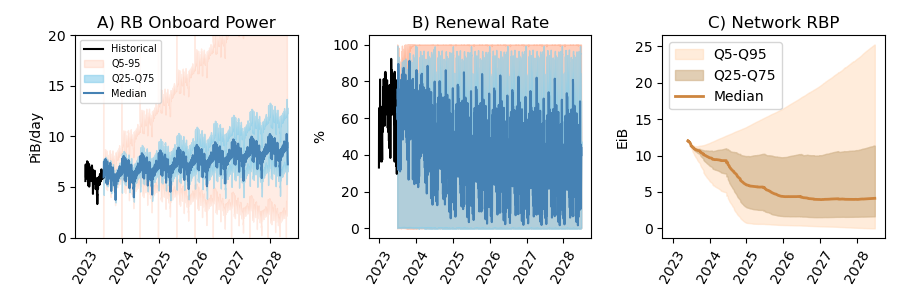

In [13]:
colors_ = [['peachpuff', 'tan', 'peru'], 
           ['powderblue', 'skyblue', 'steelblue'], 
           ['lightsalmon', 'tomato', 'firebrick']]
    
fig, axs = plt.subplots(1,3, constrained_layout=True, sharex=True, figsize=(9,3))

forecast_date_start = mcmc_train_end_date + timedelta(days=1)
forecast_x = [forecast_date_start+timedelta(days=i) for i in range(forecast_lenght)]

# add in onboarded power
q, qs = get_quantiles(df_mcmc, 'rb_onboard_power')
axs[0].plot(historical_rb_date, historical_rb, color='k', label='Historical')
axs[0].fill_between(forecast_x, qs[0], qs[-1], alpha=0.2, color=colors_[2][0], label='Q5-95')
axs[0].fill_between(forecast_x, qs[1], qs[-2], alpha=0.6, color=colors_[1][1], label='Q25-Q75')
axs[0].plot(forecast_x, qs[2], color=colors_[1][2], label='Median')
axs[0].set_title('A) RB Onboard Power')
axs[0].set_ylabel('PiB/day')
axs[0].tick_params(axis='x', labelrotation=60)
axs[0].legend(loc='upper left', fontsize=7)
axs[0].set_ylim(0,20)

q, qs = get_quantiles(df_mcmc, 'renewal_rate')
axs[1].plot(historical_rr_date, historical_rr*100, color='k', label='Historical')
axs[1].fill_between(forecast_x, qs[0], qs[-1]*100, alpha=0.5, color=colors_[2][0], label='Q5-95')
axs[1].fill_between(forecast_x, qs[1], qs[-2]*100, alpha=0.65, color=colors_[1][1], label='Q25-Q75')
axs[1].plot(forecast_x, qs[2]*100, color=colors_[1][2], label='Median')
axs[1].set_title('B) Renewal Rate')
axs[1].set_ylabel('%')
axs[1].tick_params(axis='x', labelrotation=60)
# axs[1].legend()

plt_x(axs[2], mint_df_summary, quantity_to_plot='network_RBP', scale_by=2**60,
     labels=['Q5-Q95', 'Q25-Q75', 'Median'])
axs[2].set_title('C) Network RBP')
axs[2].set_ylabel('EiB')
axs[2].tick_params(axis='x', labelrotation=60)
axs[2].legend(loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'inputs.png'))

In [14]:
@disk_utils.cache_data(directory=offline_info_dir)
def find_minting_crossings(df):
    xing = np.array([])
    for i in tqdm(range(df.iter[-1]+1)):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[(df_i.day_network_reward)*0.98 <= df_i.day_simple_reward]
        if len(df_crossing) > 0:
            xing_i = df_crossing.index[0]
            xing = np.append(xing,xing_i)
    return {'minting_cross_samples': xing}

xings = find_minting_crossings(mint_df)
locals().update(xings)

<IPython.core.display.Javascript object>


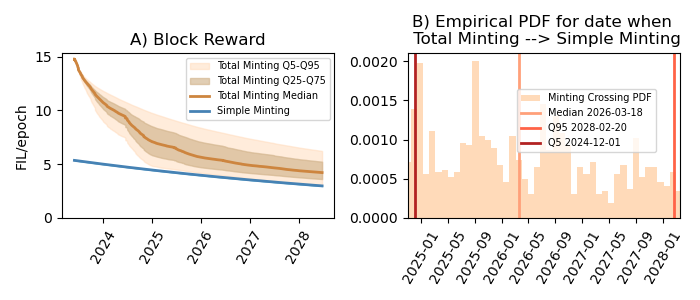

In [15]:
fig, axs = plt.subplots(1,2, constrained_layout=True, sharex=False, figsize=(7,3))

forecast_date_start = mcmc_train_end_date + timedelta(days=1)
forecast_x = [forecast_date_start+timedelta(days=i) for i in range(forecast_lenght)]

plt_x(axs[0], mint_df_summary, quantity_to_plot='day_network_reward', scale_by=(5*2880),
     labels=['Total Minting Q5-Q95', 'Total Minting Q25-Q75', 'Total Minting Median'])
plt_x(axs[0], mint_df_summary, quantity_to_plot='day_simple_reward', scale_by=(5*2880), color_idx=1, 
      labels=[None, None, 'Simple Minting'])
axs[0].set_title('A) Block Reward')
axs[0].set_ylabel('FIL/epoch')
axs[0].tick_params(axis='x', labelrotation=60)
axs[0].legend(fontsize=7)
axs[0].set_ylim(0)

axs[1].hist(minting_cross_samples,
            bins=50,
            density=True,
            label='Minting Crossing PDF', color=colors_[0][0])
cross_q50 = pd.Series(minting_cross_samples).quantile(0.5, interpolation="midpoint")
axs[1].axvline(cross_q50, color=colors_[2][0], linestyle='-', 
               lw=2, alpha=1, label=f'Median {str(cross_q50)}')
cross_q95 = pd.Series(minting_cross_samples).quantile(0.95, interpolation="midpoint")
axs[1].axvline(cross_q95, color=colors_[2][1], linestyle='-', 
               lw=2, alpha=1, label=f'Q95 {str(cross_q95)}')
cross_q5 = pd.Series(minting_cross_samples).quantile(0.05, interpolation="midpoint")
axs[1].axvline(cross_q5, color=colors_[2][2], linestyle='-', 
               lw=2, alpha=1, label=f'Q5 {str(cross_q5)}')
axs[1].set_xlim(cross_q5-timedelta(days=30), cross_q95+timedelta(days=30))
axs[1].tick_params(axis='x', labelrotation = 30)
axs[1].set_title('B) Empirical PDF for date when \n Total Minting --> Simple Minting')
axs[1].tick_params(axis='x', labelrotation = 60)
axs[1].legend(fontsize=7, loc=(0.4,0.4))

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'minting.png'))